* reward function: with coefficient
* accuracy estimation: with predictor
* next item sampling: with random_choice
* input to lstm: tokens expanded
* data_x: without 0-steps

Tokens expanded
* lstm input shape: (6, 5) 
* 5: no. of layers, 6: layer infos
* input to predict: (1, 6, 5)
* predicted output shape: (1, 6, 382) return_sequences=True
* predicts layer params

In [1]:
import numpy as np
import keras
import random
import matplotlib.pyplot as plt 
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.backend as K
import scipy.stats as stats
import math
import tensorflow as tf
import itertools
from typing import List

In [2]:
baseline = 0
rew_coef = 1
loss_alpha = -0.5
# rnn_lr = 0.01 
# rnn_decay = 0.1
no_of_nas_epochs = 40
no_of_samples_per_epoch = 10
max_no_of_layers = 6
rnn_train_epochs = 64
distribution_space = np.linspace(1,32,32)
rnn_dim = int(distribution_space[-1])
no_of_layer_params = 6

In [3]:
def plot_distribution(samples, prob, next_):
    fig, axs = plt.subplots(len(next_), figsize=(24, 6))
    for i in range(len(next_)):
        axs[i].axvline(x=next_[i], c="r", alpha=0.5)
        axs[i].plot(distribution_space, prob[i])
        axs[i].axis('off')    
    plt.show()

In [4]:
acc_model = keras.models.load_model("accuracy_predictor.h5")
def performance_estimate(sequence):
    seq_hot = keras.utils.to_categorical(sequence[:-1], num_classes=383)[np.newaxis]
    acc = acc_model.predict(seq_hot)[0][0]
    return round(acc, 3)

In [5]:
def discount_reward(rewards):
    discounted_reward = []
    for t in range(len(rewards)):
        dis_reward = 0
        for i, r in enumerate(rewards[t:]):
            dis_reward = loss_alpha**(i-t) * r
        discounted_reward.append(dis_reward)
    discounted_reward = tf.stack(discounted_reward)
    if len(rewards) > 1:
        discounted_reward = (discounted_reward - K.mean(discounted_reward)) / K.std(discounted_reward)
    return discounted_reward

In [6]:
def reinforce(y_true, y_pred):
    rewards = rew_coef * (data_acc - baseline)
    discounted_rewards = discount_reward(rewards)
    y_pred = K.clip(y_pred, 1e-36, 1e36)
    loss = - K.log(y_pred) * discounted_rewards[:, None]
    return loss

In [7]:
ranges = {
    "layers": [1, 2, 3],  # 1:"Conv2D", 2:"DepthwiseConv2D", 3:"Dense", 4:"dropout", 5:"last"
    "filters": [8, 16, 24, 32, 40],
    "nodes": [4, 8, 12, 16, 20, 24, 28, 32, 36, 40],
    "kernel_sizes": [1, 2, 3],  # 1:[1, 1], 2:[2, 2], 3:[3, 3]
    "strides": [1, 2, 3],  # 1:[1, 1], 2:[2, 2], 3:[3, 3]
    "paddings": [1, 2],  # 1:"valid", 2:"same"
    "activations": [1, 2],  # 1:"sigmoid", 2:"relu"
        }

In [8]:
# def expand_token(sequence):
def get_dictionary() -> List:
    cnn_params = list(itertools.product(*[ranges["layers"][:-1], ranges["filters"], ranges["kernel_sizes"], ranges["strides"], ranges["paddings"], 
                                          ranges["activations"]]))
    dense_params = list(itertools.product(*[[3], ranges["nodes"], [0], [0], [0], ranges["activations"]]))
    last_params = [[4, 2, 0, 0, 0, 0], [5, 2, 0, 0, 0, 0]]  # dropout 0.2, softmax 2
    dictionary = cnn_params + dense_params #+ last_params
    return dictionary
#     expanded = [dictionary[i-1] for i in sequence]
#     return expanded

In [9]:
def map_dist_to_layer_param(dist: List, param_name: str, selected: int) -> int:
    if param_name is None:
        return 0
    range_ = ranges[param_name]
    stp = int(math.ceil(len(dist)/len(range_)))
    mapped = [item for sublist in [[i]*stp for i in range_] for item in sublist]

    while len(mapped) > len(dist):
        s = np.random.randint(len(mapped))
        del mapped[s]
    value = mapped[selected-1]
    return value

In [10]:
model = keras.models.Sequential()
model.add(Dense(128, input_shape=(no_of_layer_params, max_no_of_layers-1), activation="relu")) 
model.add(Dense(128, activation="relu"))  
model.add(Dense(64, activation="relu")) 
model.add(Dense(64, activation="relu")) 
model.add(Dense(32, activation="relu")) 
model.add(Dense(32, activation="relu")) 
model.add(Dense(32, activation="relu")) 
model.add(Dense(32, activation="relu")) 
model.add(Dense(len(distribution_space), activation="softmax")) 

# model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate))

In [11]:
# model = None
# main_input = keras.engine.input_layer.Input(shape=(no_of_layer_params, max_no_of_layers-1), batch_shape=None, name="main_input")
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(main_input)
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# # x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# # x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# # x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# main_output = keras.layers.Dense(len(distribution_space), activation="softmax", name="main_output")(x)
# model = keras.models.Model(inputs=[main_input], outputs=[main_output])

In [12]:
# model = None
# main_input = keras.engine.input_layer.Input(shape=(no_of_layer_params, max_no_of_layers-1), batch_shape=None, name="main_input")
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(main_input)
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# main_output = keras.layers.Softmax(name="main_output", axis=-1)(x)
# model = keras.models.Model(inputs=[main_input], outputs=[main_output])

In [13]:
# model.compile(loss={"main_output": reinforce}, optimizer=keras.optimizers.Adam(lr=rnn_lr, decay=rnn_decay, clipnorm=1.0))
model.compile(loss=reinforce, optimizer=keras.optimizers.Adam())

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6, 128)            768       
_________________________________________________________________
dense_1 (Dense)              (None, 6, 128)            16512     
_________________________________________________________________
dense_2 (Dense)              (None, 6, 64)             8256      
_________________________________________________________________
dense_3 (Dense)              (None, 6, 64)             4160      
_________________________________________________________________
dense_4 (Dense)              (None, 6, 32)             2080      
_________________________________________________________________
dense_5 (Dense)              (None, 6, 32)             1056      
_________________________________________________________________
dense_6 (Dense)              (None, 6, 32)             1

In [15]:
# keras.utils.plot_model(model, "lstm.png", show_shapes=True)

NAS epoch 1
Epoch average accuracy (10 sequences): 0.704


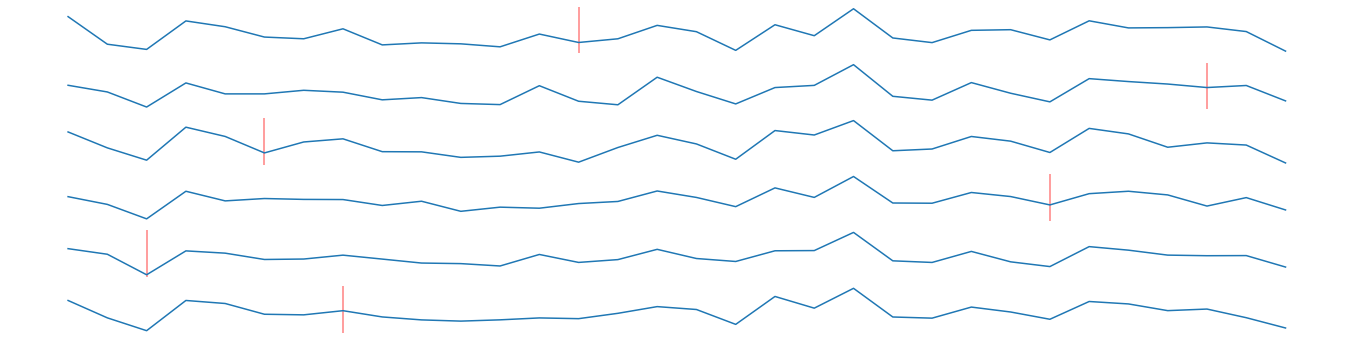

Training lstm ..
Rewards: [0.807, 0.683, 0.786, 0.525, 0.515, 0.799, 0.516, 0.781, 0.814, 0.813]
Discounted Rewards: tf.Tensor(
[[ 0.44720024]
 [ 0.44716185]
 [ 0.4470083 ]
 [ 0.44639418]
 [ 0.44393754]
 [ 0.4341111 ]
 [ 0.3948052 ]
 [ 0.2375817 ]
 [-0.39131227]
 [-2.9068882 ]], shape=(10, 1), dtype=float32)


ValueError: in user code:

    /home/amirhossein/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/amirhossein/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/amirhossein/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/amirhossein/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/amirhossein/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/amirhossein/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/amirhossein/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:756 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /home/amirhossein/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/compile_utils.py:182 __call__
        y_true = self._conform_to_outputs(y_pred, y_true)
    /home/amirhossein/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/compile_utils.py:62 _conform_to_outputs
        struct = map_to_output_names(outputs, self._output_names, struct)
    /home/amirhossein/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/compile_utils.py:587 map_to_output_names
        struct.keys(), output_names))

    ValueError: Found unexpected keys that do not correspond to any Model output: dict_keys(['main_output']). Expected: ['dense_8']


In [16]:
history_data_x = []
history_data_acc = []
history_lstm_loss = []
history_avg_acc = []
history_rewards = []
valid_layers = get_dictionary()

for nas_epoch in range(no_of_nas_epochs):
    sequences = []
    data_x = None
    accuracies = []
    data_acc = None
    print("NAS epoch", nas_epoch+1)
    sample_seq = 0
    while sample_seq < no_of_samples_per_epoch:
        sequence = np.zeros((1, no_of_layer_params, max_no_of_layers-1), dtype="int32")
        sequence_tokens = []
        layer = 0
        while layer < max_no_of_layers-1:
            distribution = model.predict(sequence)
            selected_ = []
            for prob in distribution[0]:
                selected = np.random.choice(distribution_space, size=1, p=prob)[0]
                selected_.append(selected)  
            info_0 = map_dist_to_layer_param(distribution_space, "layers", int(selected_[0])) 
            layer_params = [info_0]
            if info_0 in [1,2]:
                for i, param_name in enumerate(["filters", "kernel_sizes", "strides", "paddings", "activations"]):
                    info_ = map_dist_to_layer_param(distribution_space, param_name, int(selected_[i+1])) 
                    layer_params.append(info_)
            if info_0 == 3:
                for i, param_name in enumerate(["nodes", None, None, None, "activations"]):
                    info_ = map_dist_to_layer_param(distribution_space, param_name, int(selected_[i+1])) 
                    layer_params.append(info_)
                    
            if tuple(layer_params) in valid_layers:
                sequence[0][:,layer] = layer_params
                sequence_tokens.append(valid_layers.index(tuple(layer_params))+1)
                layer += 1
                
        if not any(np.array_equal(sequence, x) for x in sequences):
            sequences.append(sequence)
            sequence_acc = performance_estimate(sequence_tokens + [int(distribution_space[-1])])
            accuracies.append(sequence_acc)
            sample_seq += 1

        data_acc = np.vstack(accuracies)
    
    avg_acc = round(np.average(accuracies),3)
    print(f"Epoch average accuracy ({no_of_samples_per_epoch} sequences):", avg_acc)
#     baseline = avg_acc + 0.05
    plot_distribution(distribution_space, distribution[0], selected_)
    print("Training lstm ..")
    rewards_ = rew_coef * (data_acc - baseline)
    discounted_rewards_ = discount_reward(rewards_)
    print("Rewards:", [round(i[0], 4) for i in rewards_])
    print("Discounted Rewards:", discounted_rewards_)
    data_x = np.array(sequences).reshape(len(sequences), no_of_layer_params, max_no_of_layers-1)
    data_y = np.zeros(tuple(list(data_x.shape) + [len(distribution_space)]))
    history = model.fit({'main_input': data_x},
                        {'main_output': data_y},
                        epochs=rnn_train_epochs,
                        batch_size=len(data_x),
                        verbose=0)
    lstm_loss_avg = np.average(list(history.history.values())[0])
    print("lstm loss (epochs average):", lstm_loss_avg)
    
    history_avg_acc.append(avg_acc)
    history_lstm_loss.append(lstm_loss_avg)
    history_data_x.append(data_x)
    history_data_acc.append(data_acc)   
    history_rewards.append(rewards_) 
print("Done.")

In [ ]:
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(history_avg_acc)), history_avg_acc)
plt.title("Average epoch accuracy")
plt.grid()
plt.show()
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(history_lstm_loss)), history_lstm_loss)
plt.title("LSTM loss")
plt.axhline(y=0, c="k")
plt.grid()
plt.show()

fig, ax1 = plt.subplots(figsize=(24, 6))
ax2 = ax1.twinx()

all_acc_avg = [[np.average(i)] for i in history_data_acc]
all_acc_avg = [item for sublist in all_acc_avg for item in sublist]

ax1.plot(np.arange(0,len(all_acc_avg)), all_acc_avg, c="g")
ax2.plot(np.arange(0,len(history_lstm_loss)), history_lstm_loss, c="b")
ax2.axhline(y=0, c="gray")

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy", color='g')
ax2.set_ylabel("Loss", color='b')
plt.grid()
plt.show()

In [ ]:
fig = plt.figure(figsize=(24, 4))
all_rew = np.array(history_rewards)
all_rew = all_rew.reshape(all_rew.shape[0]*all_rew.shape[1],1)

rewards_avg = [[np.average(i)]*no_of_samples_per_epoch for i in history_rewards]
rewards_avg = [item for sublist in rewards_avg for item in sublist]

plt.plot(np.arange(0,len(all_rew)), all_rew, label="all")
plt.plot(np.arange(0,len(rewards_avg)), rewards_avg, label="epoch_average")
plt.title("Rewards")
plt.legend()
plt.grid()
plt.show()

In [ ]:
fig = plt.figure(figsize=(24, 6))
all_acc = np.array(history_data_acc)
all_acc = all_acc.reshape(all_acc.shape[0]*all_acc.shape[1],1)
plt.plot(np.arange(0,len(all_acc)), all_acc, label="all")

all_acc_avg = [[np.average(i)]*no_of_samples_per_epoch for i in history_data_acc]
all_acc_avg = [item for sublist in all_acc_avg for item in sublist]
plt.plot(np.arange(0,len(all_acc_avg)), all_acc_avg, label="epoch_average")

# plt.axhline(y=baseline, c="r", label="baseline")
plt.axhline(y=np.average(all_acc), c="g", label="average")
plt.title("Accuracies")
plt.xticks(range(0,len(all_acc), no_of_samples_per_epoch))
plt.ylim([0.4,1])
plt.grid()
plt.legend()
plt.show()
print("Total accuracy average:", np.average(all_acc))
print("Best accuracy:", np.max(all_acc))

In [ ]:
# random_acc = []
# for i in range(len(all_acc)):
#     random_acc.append(performance_estimate(np.random.randint(low=1, high=len(distribution_space), size=max_no_of_layers)))

# fig = plt.figure(figsize=(24, 6))
# plt.plot(np.arange(0,len(random_acc)), random_acc)
# plt.ylim([0,1])
# plt.grid()
# plt.xticks(range(0,len(all_acc), no_of_samples_per_epoch))
# plt.axhline(y=baseline, c="r")
# plt.axhline(y=np.average(random_acc), c="g")
# plt.title("Random")
# plt.show()
# print(np.average(random_acc))